## We'll start with handling the missing data and then focus on building the models

# Data preprocessing
## Overview

* remove skewenes of target feature
* remove skewenes of numeric features isf exists
* handle missing values in categorical features
* handle missing values in numerical features
* feature selection

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [124]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [125]:
target = train['SalePrice']
target_log = np.log1p(train['SalePrice'])

In [126]:
# drop target variable from train dataset
train = train.drop(["SalePrice"], axis=1)

**Concat train and test dataset in order for pre-processing**

In order to apply transformations on data, we have to concatenate both datasets: train and

In [127]:
data = pd.concat([train, test], ignore_index=True)

## Split dataframe into numeric and categorical
### Split dataframe into 2 with:

* categorical feature space
* numerical feature space

In [128]:
# save all categorical columns in list
categorical_columns = [col for col in data.columns.values if data[col].dtype == 'object']

# dataframe with categorical features
data_cat = data[categorical_columns]
# dataframe with numerical features
data_num = data.drop(categorical_columns, axis=1)

# Reduce skewness for numeric features


In [129]:
from scipy.stats import skew
data_num_skew = data_num.apply(lambda x: skew(x.dropna()))
data_num_skew = data_num_skew[data_num_skew > .75]

# apply log + 1 transformation for all numeric features with skewnes over .75
data_num[data_num_skew.index] = np.log1p(data_num[data_num_skew.index])

## Handling missing values in numerical columns

In [130]:
data_len = data_num.shape[0]

# check what is percentage of missing values in categorical dataframe
for col in data_num.columns.values:
    missing_values = data_num[col].isnull().sum()
    #print("{} - missing values: {} ({:0.2f}%)".format(col, missing_values, missing_values/data_len*100)) 
    
    # drop column if there is more than 50 missing values
    if missing_values > 50:
        #print("droping column: {}".format(col))
        data_num = data_num.drop(col, axis = 1)
    # if there is less than 50 missing values than fill in with median valu of column
    else:
        #print("filling missing values with median in column: {}".format(col))
        data_num = data_num.fillna(data_num[col].median())
    

## Handling missing values in categorical columns


In [131]:
data_len = data_cat.shape[0]

# check what is percentage of missing values in categorical dataframe
for col in data_cat.columns.values:
    missing_values = data_cat[col].isnull().sum()
    #print("{} - missing values: {} ({:0.2f}%)".format(col, missing_values, missing_values/data_len*100)) 
    
    # drop column if there is more than 50 missing values
    if missing_values > 50:
        print("droping column: {}".format(col))
        data_cat.drop(col, axis = 1)
    # if there is less than 50 missing values than fill in with median valu of column
    else:
        #print("filling missing values with XXX: {}".format(col))
        #data_cat = data_cat.fillna('XXX')
        pass

droping column: Alley
droping column: BsmtQual
droping column: BsmtCond
droping column: BsmtExposure
droping column: BsmtFinType1
droping column: BsmtFinType2
droping column: FireplaceQu
droping column: GarageType
droping column: GarageFinish
droping column: GarageQual
droping column: GarageCond
droping column: PoolQC
droping column: Fence
droping column: MiscFeature


In [132]:
data_cat_dummies = pd.get_dummies(data_cat)


In [133]:
data_num.shape


(2919, 37)

In [134]:
data_cat.shape

(2919, 43)

In [135]:
data = pd.concat([data_num, data_cat_dummies], axis=1)


In [136]:
train = data.iloc[:len(train)-1]
train = train.join(target_log)

test = data.iloc[len(train)+1:]

## Modeling

In [137]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
def rmse_cv(model):
    rmse = np.sqrt(mean_absolute_error(model, X_train, y_train))
    return(rmse)

In [138]:
# remove Id and target variable
X_train = train[train.columns.values[1:-1]]
y_train = train[train.columns.values[-1]]

# remove Id
X_test = test[test.columns.values[1:]]

# Simple Linear Regression Model

In [139]:
from sklearn.linear_model import LinearRegression

In [140]:
model_linear=LinearRegression()

In [141]:
model_linear.fit(X_train,y_train)

LinearRegression()

In [142]:
y_test_pred_log = model_linear.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(y_test_pred_log)})
submission.to_csv("LinearRegressionModel.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,121171.143130
1461,1462,163043.079400
1462,1463,188298.272392
1463,1464,200421.509810
1464,1465,199481.418095


# Linear regression with regularisation - RIDGE

In [143]:
from sklearn.linear_model import Ridge, RidgeCV

In [144]:
model_rige = Ridge()

In [145]:
def CV(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 7))
    return(rmse)

In [146]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [CV(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [147]:
cv_ridge

[0.1344695725661709,
 0.13337484615189024,
 0.1312301253283727,
 0.12902508671729787,
 0.12767650767689537,
 0.12732765694833498,
 0.12725428003377276,
 0.12754900937070107,
 0.12896755399011928,
 0.13096025157415267,
 0.13317527577329022]

Text(0, 0.5, 'rmse')

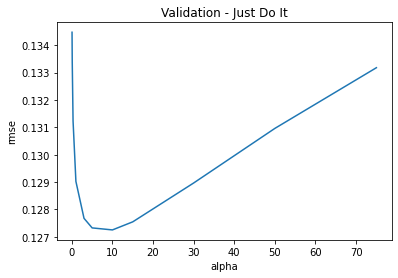

In [148]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [149]:
# let train again model with alpha = 10
model_ridge = Ridge(alpha = 10).fit(X_train, y_train)
CV(model_ridge).mean()

0.12725428003377276

In [150]:
y_test_pred_log = model_ridge.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(y_test_pred_log)})
submission.to_csv("RidgeRegression.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,118494.791118
1461,1462,152088.580809
1462,1463,181185.139124
1463,1464,196802.446394
1464,1465,199980.188516


# Linear regression with regularisation - LASSO

In [151]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [152]:
CV(model_lasso).mean()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21615221269115636, tolerance: 0.016282014759334842
  model = cd_fast.enet_coordinate_descent_gram(


0.12246221863023751

In [153]:
lasso_pred_log = model_lasso.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(lasso_pred_log)})
submission.to_csv("LassoRegression.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,119570.361706
1461,1462,151043.618792
1462,1463,180496.118509
1463,1464,197036.633019
1464,1465,202147.010820


# RandomForest

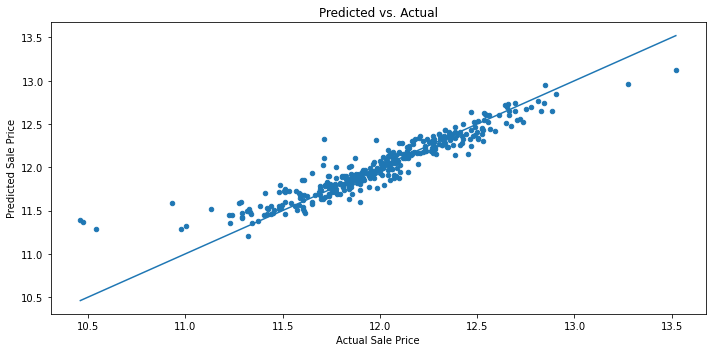

In [154]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
model_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf.fit(X_train1, y_train1)
rf_pred = model_rf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, rf_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [155]:
model_rf.fit(X_train, y_train)
rf_pred_log = model_rf.predict(X_test)

In [156]:
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(rf_pred_log)})
submission.tail(1)

,Id,SalePrice
2918,2919,233625.518613


In [157]:
submission.to_csv("RandomForest.csv", index=False)

# Xgboost 

In [158]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

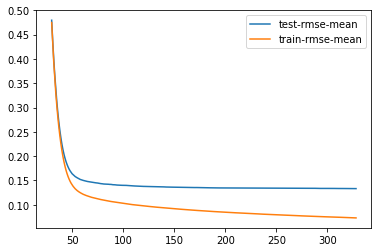

In [159]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


In [160]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

[02:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2, n_estimators=360)

In [161]:
xgb_preds_log = model_xgb.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(xgb_preds_log)})
submission.to_csv("XGBoost.csv", index=False)
submission.head()


,Id,SalePrice
1460,1461,120140.609375
1461,1462,157370.546875
1462,1463,185639.281250
1463,1464,190348.687500
1464,1465,186588.140625


# GradientBoosting

In [163]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

model_gbm = GradientBoostingRegressor(**params)
model_gbm.fit(X_train, y_train)

CV(model_gbm).mean()

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in v

0.20781600195233624

In [164]:
gbm_preds_log = model_gbm.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(gbm_preds_log)})
submission.to_csv("GradientBoosting.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,142253.172997
1461,1462,155418.751852
1462,1463,178388.315331
1463,1464,165275.246472
1464,1465,185162.165686


In [171]:
#param_grid = {
#        'max_depth': [2, 4], 
#        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
#        'min_child_weight': range(1, 10, 2),
#        'n_estimators': range(50, 300, 50),
#        'objective': ['reg:linear']}
#grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=KFold,verbose=1, scoring=make_scorer)
#grid_result = grid_search.fit(X_train, y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Neural Network

In [172]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    #Input layer
    model.add(Dense(20, input_dim=288, activation='relu'))
    #Hidden layer
    model.add(Dense(40, activation='relu'))
    #Output layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
NN=keras_model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)

Epoch 1/50
15/15 [==============================] - 1s 2ms/step - loss: -2471.6606 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: -7318.4604 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: -15670.6445 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: -30307.6582 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: -54172.9180 - accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: -91281.1641 - accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: -145541.4688 - accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: -220968.4688 - accuracy: 0.0000e+00
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: -321541.6250 - accuracy: 0.0000e+00
Epoch 10/50
15/15 [=================

In [173]:
NN_preds_log = keras_model.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(gbm_preds_log)})
submission.to_csv("NN.csv", index=False)
submission.head()

46/46 [==============================] - 0s 1ms/step


,Id,SalePrice
1460,1461,142253.172997
1461,1462,155418.751852
1462,1463,178388.315331
1463,1464,165275.246472
1464,1465,185162.165686
